# `column_mass_plot.ipynb`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import math
import pandas as pd
import Leadangle_wave as Wave

from Leadangle_fit_JunoUVS import eqwlong_err
from Leadangle_fit_JunoUVS import create_argmesh
from Leadangle_fit_JunoUVS import local_time_moon

from UniversalColor import UniversalColor
from SharedX import ShareXaxis
from legend_shadow import legend_shadow

from scipy.odr import ODR, Model, RealData

UC = UniversalColor()
UC.set_palette()

F = ShareXaxis()
F.fontsize = 20
F.fontname = 'Liberation Sans Narrow'
F.set_default()

# F.set_figparams()
# F.initialize()

Importing Library
done


In [2]:
exname = '003/20250516_Io'
target_moon = 'Io'
target_fp = ['MAW']
Zi = 1.3
Te = 6     # [eV]

# メモ
# 001/20250423_001: 3d (50, 3, 60) Eu [MAW] (PJ 7)
# 001/20250423_002: 3d (50, 3, 60) Eu [MAW] (PJ 10)
# 001/20250423_003: 3d (50, 3, 60) Eu [MAW] (PJ 3)
# 001/20250423_004: 3d (50, 3, 60) Eu [MAW] (PJ 4)
# 001/20250423_005: 3d (50, 3, 60) Eu [MAW] (PJ 11)
# -
# 002/20250427_001: 3d (50, 3, 60) Eu [MAW] (PJ 7)
# 002/20250427_002: 3d (50, 3, 60) Eu [MAW] (PJ 10)
# 002/20250427_003: 3d (50, 3, 60) Eu [MAW] (PJ 3)
# 002/20250427_004: 3d (50, 3, 60) Eu [MAW] (PJ 4)
# 002/20250427_005: 3d (50, 3, 60) Eu [MAW] (PJ 11)
# 002/20250427_006: 3d (50, 3, 60) Io [MAW] (PJ 3)
# 002/20250427_007: 3d (50, 3, 60) Io [MAW] (PJ 5)
# 002/20250427_008: 3d (50, 3, 60) Io [MAW] (PJ 7)
# 002/20250427_009: 3d (50, 3, 60) Io [MAW] (PJ 8)


Ai_info = np.loadtxt('results/column_mass/'+exname+'/params_Ai.txt')
ni_info = np.loadtxt('results/column_mass/'+exname+'/params_ni.txt')
Ti_info = np.loadtxt('results/column_mass/'+exname+'/params_Ti.txt')
col_massdens_1d = np.loadtxt(
    'results/column_mass/'+exname+'/col_massdens_1d.txt')

# パラメータ空間(meshgrid → 1d)の作成
Ai_1d, ni_1d, Ti_1d, _, _, _ = create_argmesh(Ai_info[0], Ai_info[1], int(Ai_info[2]), 'linear',
                                              ni_info[0], ni_info[1], int(
                                                  ni_info[2]), 'log',
                                              Ti_info[0], Ti_info[1], int(Ti_info[2]), 'log')

col_massdens_3d = col_massdens_1d.reshape(
    int(ni_info[2]), int(Ai_info[2]), int(Ti_info[2]))

Ai_3d = Ai_1d.reshape(int(ni_info[2]), int(Ai_info[2]), int(Ti_info[2]))
ni_3d = ni_1d.reshape(int(ni_info[2]), int(Ai_info[2]), int(Ti_info[2]))
Ti_3d = Ti_1d.reshape(int(ni_info[2]), int(Ai_info[2]), int(Ti_info[2]))

print('Parameter ranges:')
print('Ai:', np.min(Ai_3d), np.max(Ai_3d))
print('ni:', np.min(ni_3d), np.max(ni_3d))
print('Ti:', np.min(Ti_3d), np.max(Ti_3d))

Parameter ranges:
Ai: 20.0 24.0
ni: 499.9999999999999 4999.9999999999945
Ti: 9.999999999999998 999.9999999999999


In [3]:
# %% Constants
MU0 = 1.26E-6            # 真空中の透磁率
AMU2KG = 1.66E-27        # 原子質量をkgに変換するファクタ [kg]
RJ = 71492E+3            # JUPITER RADIUS [m]
MJ = 1.90E+27            # JUPITER MASS [kg]
C = 2.99792E+8           # LIGHT SPEED [m/s]
G = 6.67E-11             # 万有引力定数  [m^3 kg^-1 s^-2]

Psyn_io = (12.89)*3600      # Moon's synodic period [sec]
Psyn_eu = (11.22)*3600      # Moon's synodic period [sec]
Psyn_ga = (10.53)*3600      # Moon's synodic period [sec]

if target_moon == 'Io':
    Psyn = Psyn_io
    r_moon = 5.9*RJ
    xticks = np.array([1, 10, 100, 500, 1000, 5000])
elif target_moon == 'Europa':
    Psyn = Psyn_eu
    r_moon = 9.4*RJ
    xticks = np.array([1, 10, 100, 500, 1000, 5000])
elif target_moon == 'Ganymede':
    Psyn = Psyn_ga
    r_moon = 15.0*RJ
    xticks = np.array([1, 10, 100, 1000])

(60, 50)
(60, 50)
(60, 50)


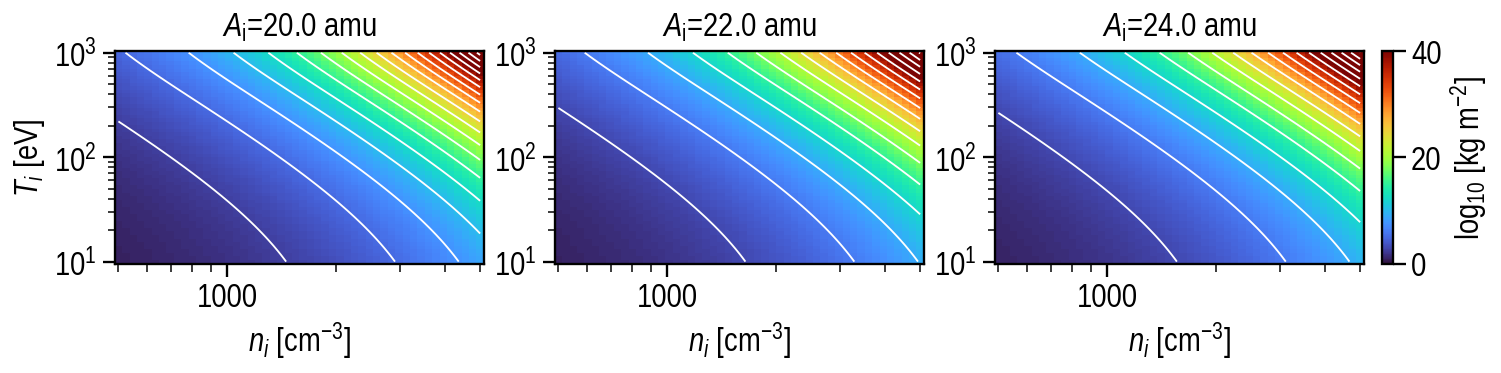

In [20]:
# 横軸 ni
fig, ax = plt.subplots(1, 3, figsize=(12.4, 3), dpi=120, layout='constrained')
for i in range(3):
    z_value = col_massdens_3d[:, i, :].T
    # z_value = np.log10(z_value)
    z_value = z_value*1E+9
    print(z_value.shape)

    x_value = ni_3d[:, i, :].T
    y_value = Ti_3d[:, i, :].T

    # Scale height -> Ti
    Ti_thres = ((2.0*RJ)**2)*Ai_3d[0, i, 0]/((0.64*RJ)**2) - Zi*Te

    ax[i].set_title(
        r'$A_{\rm i}$='+str(Ai_3d[0, i, 0])+' amu',
        pad=9)
    ax[i].set_xlabel(r'$n_i$ [cm$^{-3}$]')
    ax[0].set_ylabel(r'$T_i$ [eV]')
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xticks(np.array([1, 10, 100, 1000]))
    ax[i].set_xticklabels(np.array([1, 10, 100, 1000]))
    cn = ax[i].contour(x_value, y_value, z_value,
                       colors='w',
                       levels=19,
                       linewidths=1.1,
                       zorder=2)
    p = ax[i].pcolormesh(x_value,
                         y_value,
                         z_value,
                         cmap='turbo',
                         vmin=0, vmax=40,
                         zorder=0.5)

fig.colorbar(p, label='log$_{10}$ [kg m$^{-2}$]')
plt.show()

In [5]:
z_value[1:-1, 1:-1].shape

(58, 48)

In [6]:
z_value.shape

(60, 50)

(60, 49)
(60, 49)
(60, 49)


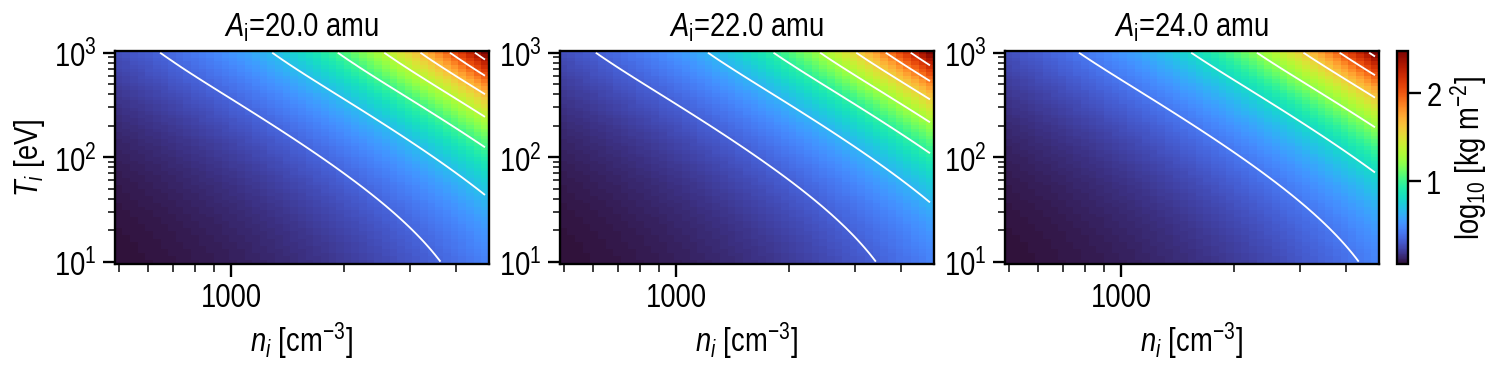

In [9]:
# 横軸 ni
fig, ax = plt.subplots(1, 3, figsize=(12.4, 3), dpi=120, layout='constrained')
for i in range(3):
    z_value = col_massdens_3d[:, i, :].T-np.min(col_massdens_3d[:, i, :])
    z_value *= 1E+9
    z_value = np.abs(z_value[:, 0:-1] - z_value[:, 1:])

    print(z_value.shape)

    x_value = ni_3d[:, i, :].T
    x_value = x_value[:, 0:-1]
    y_value = Ti_3d[:, i, :].T
    y_value = y_value[:, 0:-1]

    # Scale height -> Ti
    Ti_thres = ((2.0*RJ)**2)*Ai_3d[0, i, 0]/((0.64*RJ)**2) - Zi*Te

    ax[i].set_title(
        r'$A_{\rm i}$='+str(Ai_3d[0, i, 0])+' amu',
        pad=9)
    ax[i].set_xlabel(r'$n_i$ [cm$^{-3}$]')
    ax[0].set_ylabel(r'$T_i$ [eV]')
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xticks(np.array([1, 10, 100, 1000]))
    ax[i].set_xticklabels(np.array([1, 10, 100, 1000]))
    cn = ax[i].contour(x_value, y_value, z_value,
                       colors='w',
                       linewidths=1.1,
                       zorder=2)
    p = ax[i].pcolormesh(x_value,
                         y_value,
                         z_value,
                         cmap='turbo',
                         zorder=0.5)

fig.colorbar(p, label='log$_{10}$ [kg m$^{-2}$]')
plt.show()